<div class="alert alert-danger">

**Refresh your knowledge of the provided classes *BayesNet* and *Variable* by reading the `BayesNet Introduction` notebook** before you start working on this problem set! It contains a detailed description of the provided classes (*BayesNet* and *Variable*). 
    
</div>


# Structure Learning
## Problem Set 4 

## Probabilistic Models UE

---

In the fourth assignment, you will implement methods that learn the *structure* and *parameters* of a Bayesian network using *score-based search*. In particular, you will implement:

* complete search in space restricted by a pre-determined variable order
* greedy local search in the full search space


You will then help our medicine freshman from the previous problem set to use these functions and automatically find a good graph structure for her stroke model.

## Submission

**Due-Date:** see Moodle
 
**Automatic Grading:** 

- Replace the placeholders `# YOUR CODE HERE` `raise NotImplementedError()` / `YOUR ANSWER HERE` with your code / answers.
- Put results in the corresponding variable; otherwise, we will not grade your solution (i.e., we assign 0 points).
- Do not delete or add cells.

<div class="alert alert-warning">
    
**Submission:** As a ZIP-package via Moodle; the ZIP-package **must have the following structure**:
    
    <student ID, (k + 8 digits), e.g. k01234567>.zip
    +-- Problem_1.ipynb
    |-- Supplementary Materials (optional)
    + 

**Questions?** Post them into the Problem Set Forum!        
</div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Iterator, List
from bayesian_network import BayesNet, Variable
from utils import maximum_likelihood_estimate, log_likelihood, get_default_bayes_net
from utils import sample_forward, draw_graph, evaluate_bayes_net

#### General Remarks

The following is a quick refresher on how to use the BayesNet class, including an introduction to visually depicting a Bayesian Network structure from a BayesNet object. Assume we want to encode the model that factorizes in the following way:

$$ P(A, B, C) = P(A) \cdot P(B \mid A) \cdot P(C \mid A, B).$$

Variables $A, B$ and $C$ will get indices 0, 1, and 2, respectively. The corresponding list will then look like this (following the same naming conventions as used in the previous exercises):

In [2]:
_A_, _B_, _C_ = 0, 1, 2
# create dummy PDTs
pdts = [
    (np.ones((2,))*0.5, (_A_,)), 
    (np.ones((2,2))*0.5, (_B_, _A_)), 
    (np.ones((2,2,2))*0.5, (_C_, _A_, _B_))
]

Each tuple in the list corresponds to a variable, where
 - the first element in each tuple contains the (conditional) PDT, 
 - the second one describes the table's semantics (indices).

A new BayesNet can be created by passing a tuple for each variable to the constructor. Use the asterisk (\*) operator to pass an arbitrary number of tuples as arguments to the constructor:

In [3]:
bn = BayesNet(*pdts)

You can access the PDTs and the corresponding indices of a *BayesNet* object via the member variables `pdts` and `indices`, respectively:

In [4]:
print(bn.pdts)
print(bn.indices)

(array([0.5, 0.5]), array([[0.5, 0.5],
       [0.5, 0.5]]), array([[[0.5, 0.5],
        [0.5, 0.5]],

       [[0.5, 0.5],
        [0.5, 0.5]]]))
((0,), (1, 0), (2, 0, 1))


Note that they are returned as tuples to make sure they should not be modified. With `list(bn.pdts)` and `list(bn.indices)` you can convert them back to lists if needed.

We are also providing a new utility function to draw the structure of a BayesNet:

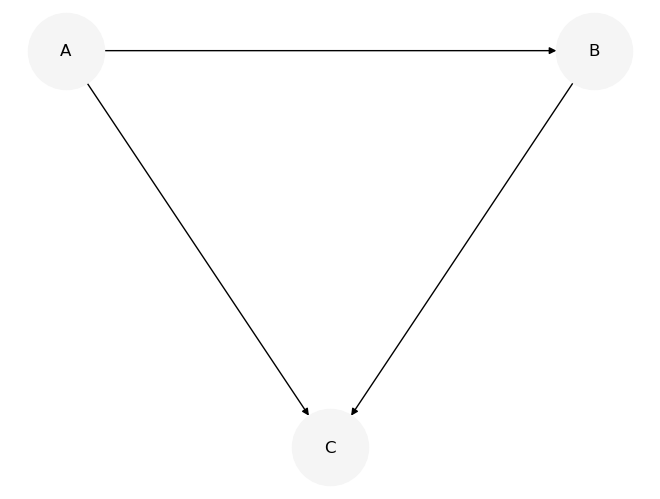

In [5]:
draw_graph(
    bn, 
    node_names=['A', 'B', 'C'], 
    pos={'A': [0., 1.], 'B': [1., 1.], 'C': [.5, .5]}
)

In [6]:
help(draw_graph)

Help on function draw_graph in module utils:

draw_graph(bayes_net: bayesian_network.BayesNet, node_names: list = None, pos: dict = None) -> None
    Draws the Bayesian net.
    :param bayes_net: a BayesNet object representing the graph structure to draw.
    :param node_names: Display Name of the variables. 
                       Defaults to values for the stroke-example.
    :param pos: position of the variables (dict: key=variable_name, value: list: x, y). 
                Defaults to values for the stroke-example.



### Bayes Information Criterion

<div class="alert alert-warning">
    Implement the <i>bic_score</i> function, which computes the Bayes Information Criterion Score (BIC-Score) for a network graph structure under the given data, assuming a Dirichlet prior over the model parameters. (2 points)
</div>

`bic_score` takes two parameters:
- `data` is a NumPy array of shape `(num_samples, num_variables)`.
- `bayes_net` is a BayesNet object, representing the graph structure for which to compute the BIC-Score. *Assume that the parameters of this bayes_net are set to the maximum likelihood estimate w.r.t. to the data*.

`bic_score` must return one object:
- The BIC-Score, a floating-point number < 0.


*Hint*:
- **You *may* assume that all variables are boolean.**
- Use the formula from the lecture slides (slide deck 5b, pp. 48-51)!
- The dimension of a Bayes net is the total number of independent (non-redundant) parameters in the Bayes net.
- Use the natural logarithm for your computations, i.e. `np.log`.
- You can use `Variable.num_values` to fetch the cardinality of a Variable. This is especially helpful for a general solution, where Variables can have more than 2 values. 
- Use our implementation of `log_likelihood` (see below) to compute the log-likelihood of the model relative to the data.

In [7]:
help(log_likelihood)

Help on function log_likelihood in module utils:

log_likelihood(data: numpy.ndarray, bayes_net: bayesian_network.BayesNet) -> float
    Computes the log-likelihood of a given Bayesian network relative to the data.
    :param data: data to compute the log-likelihood relative to.
    :param bayes_net: Bayesian network model.
    :returns: the log-likelihood of the Bayesian network relative to the data.



In [8]:
def bic_score(data: np.ndarray, bayes_net: BayesNet) -> float:
    """
    Computes the Bayesian information criterion score assuming a Dirichlet prior over the model parameters.
    :param data:      data to compute the bic score of, a np.ndarray of shape (num_samples, len(bayes_net)).
    :param bayes_net: the model, a BayesNet object.
    :return:          BIC score
    """
    
    assert data.shape[1] == len(bayes_net)
    
    bic = 0
    
    
    logM = np.log(data.shape[0])
    l = log_likelihood(data, bayes_net)
    
    # determine the dimension of Bayes net, consider non-redunancy!:
    dim_bayes_net = 0
    for variable in bayes_net:
        
        parents_combi = 1
        number_parents = len(variable.parents)
        
        for p_id in variable.parents:
            p = bayes_net[p_id]
            parents_combi *= p.num_values
        
        independent_para_current_node = parents_combi * (variable.num_values - 1)
        # last column of each pdt is redundant and can be therefore dropped.
                
        # alternative: work directly with shape of pdt
    
        dim_bayes_net += independent_para_current_node # addition, vgl. lecture 03, p. 38

    # final formula:
    bic = l - logM * dim_bayes_net / 2
    
    return bic

In [9]:
# sanity check
bayes_net = get_default_bayes_net()
data = np.array([[0,0,0,0,0], [1,1,1,1,1], [1,1,0,0,0]], dtype=np.int64)

bic = bic_score(data, bayes_net)
assert isinstance(bic,float), f'`bic_score` should return type float but returns {type(bic)}'
assert -16 < bic < -15, f'BIC needs to be in ]-16, -15[, but got {bic}'



## Complete Search in Restricted Space

In the first part, we will focus on complete search in a restricted space.

<div class="alert alert-warning">
Implement <i>complete_search</i>, a function that learns the structure and parameters of a Bayesian net using score-based search over a search space restricted by a pre-determined variable order. (4 points)
</div>

`complete_search` takes three parameters:
- `data` is a NumPy array of shape `(num_samples, num_variables)`.
- `variable_order` is a list of variable ids (ints) specifying the topological order.
- `score_fun` is the function used to score the candidate graph structure — defaults to `bic_score`. Higher score means better model. 

`complete_search` must return one object:
- a BayesNet object, which represents the model with the highest score under the given topological order.

*Hints:*
- Use `score_fun` to compute the score. Do not directly call your implementation of `bic_score`.
- You may use [`itertools.combinations`](https://docs.python.org/3/library/itertools.html#itertools.combinations) to get combinations of parent variables. For the N-th variable in `variable_order`, there are exactly $2^{N-1}$ possible parent sets to be considered.
- [`itertools.chain.from_iterable`](https://docs.python.org/3/library/itertools.html#itertools.chain.from_iterable) might become handy for flattening lists of lists of variable indexes.
- Mind that python-objects, such as lists, are passed by reference; updating a value in the list will affect all objects holding the reference! To avoid unintended change, create a copy of the list before you modify it:
```python
best_pdts.copy()
```
- Use a BayesNet only consisting of independent Variables (e.g. no connections) as starting point. Iteratively compare it with other ones and always keep the best.
- Use the provided implementation of `maximum_likelihood_estimate` to estimate the parameters of a table:

In [10]:
help(maximum_likelihood_estimate)

Help on function maximum_likelihood_estimate in module utils:

maximum_likelihood_estimate(data: numpy.ndarray, variable_id: int, parent_ids: tuple = (), laplace=1) -> numpy.ndarray
    Estimates the conditional probability distribution of a (discrete) variable from data.
    :param data: data to estimate distribution from
    :param variable_id: column index corresponding to the variable we estimate the distribution for
    :param parent_ids: column indices of the variables the distribution is conditioned on
    :param laplace: Laplace smoothing with this alpha
    :returns: estimated conditional probability distribution table



In [11]:
import itertools as it
import copy
def complete_search(data: np.ndarray, variable_order: list, score_fun=bic_score) -> BayesNet:
    """ 
    Learns the structure and parameters of a Bayesian net using score-based search over a 
        search space restricted by a pre-determined variable order.
    :param data: the training data, a NumPy array of shape (num_samples, len(bayes_net)).
    :param variable_order: a list containing the topological order of the variables (list of indices).
    :param score_fun:  is the function used to score the candidate graph structure — defaults to `bic_score`. 
    :return: a BayesNet object, which represents the model with the highest BIC-Score under the given topological order.
    """
    assert len(variable_order) == data.shape[1]
    
    best_pdts = [maximum_likelihood_estimate(data, variable_id) for variable_id in variable_order]
    best_indices = [(variable_id,) for variable_id in variable_order]
    # you can create a BayesNet from these descriptors with:
    best_model = BayesNet(*zip(best_pdts, best_indices)) 
    
    
    # instructions already started with no connection model; evaluate compute its score:
    score_max = score_fun(data, best_model)

    # loop over all variables:
    for var_pos, var_ind in enumerate(variable_order[1:]): # topological

        better_found = False
        
        # for each variable find out the best potential parents leading to highest score:
        ancestors = variable_order[:var_pos+1]
        
        for ancestor_number in range(1, len(ancestors)+1): # consider number of potential parents from 1 parent
            # up to all ancestors as parents
    
            parents_combis = it.combinations(ancestors, ancestor_number) # gives all possible parent
            # combinations for a fixed number of parents.
            # It doesn't care about the ordering, e.g. (0,1)=(1,0) and therefore it only produces (0,1), nice.

            for parent_option in parents_combis:

                est_pdt = maximum_likelihood_estimate(data=data, variable_id=var_ind, parent_ids=parent_option)
                # gives the distribution estimate

                bayes_var_input = [var_ind] + list(parent_option)

                current_pdts = best_pdts.copy()
                current_indices = best_indices.copy()
                
                # pdt and current indidices lists are also topological sorted meaning that we need 
                # the simple index position of the current variable within the provided variable
                # order list!
                current_pdts[var_pos+1] = est_pdt
                current_indices[var_pos+1] = tuple(bayes_var_input) 
                
                current_bayes_net = BayesNet(*zip(current_pdts, current_indices))
                # put in (distribution estimate, [indices])
                
                current_score = score_fun(data, current_bayes_net)

                if current_score > score_max:
                    best_pdt_part = est_pdt
                    best_ind_part = tuple(bayes_var_input)
                    
                    better_found = True
                    score_max = current_score
                    
        # store best parent option for the current variable:
        if better_found == True:
            
            best_pdts[var_pos+1] = best_pdt_part
            best_indices[var_pos+1] = tuple(best_ind_part)
        
    best_model = BayesNet(*zip(best_pdts, best_indices))

    return best_model


In [12]:
data = np.array([[0,0,0,0,1],[0,0,0,1,0],[0,1,0,1,0],[1,0,0,1,0],[0,1,0,0,1],[1,0,0,0,1]]*10, dtype=np.int64)
bayes_net = complete_search(data, [0,1,2,3,4])
assert len(bayes_net) == 5, f'\nBayesNet should contain all 5 Variables.' \
                            f'\nIt only contained {len(bayes_net)} being {set(it.chain(*bayes_net.indices))}.'\
                            f'\nMissing: {set(range(5))-set(it.chain(*bayes_net.indices))}.'\
                            f'\nMost likely there is an error in how you construct your `new` BayesNet during learning.'

assert np.all(np.isclose(bayes_net.pdts[0], np.array([0.66, 0.33]), atol=0.01))
assert bayes_net.indices[1] == (1,0), 'Algorithm should favor connection B_A'

bayes_net = complete_search(data, [0,1,2,3,4], score_fun=lambda d, n: 0.0)
assert bayes_net.indices[1] == (1,), 'it seems complete_search() uses bic_score() instead of score_fun()'


## Heuristic Search in Full Space

In the second part, you will implement heuristic search in the full search space. In contrast to *Complete Search in Restricted Space*, we do not restrict the search space, but we still can not afford to search the complete space. Instead, our search algorithm will only visits a small part of the full search space, guided by a heuristic function.   

In the following, you will implement the five functions:

- `is_acyclic(bn: BayesNet) -> bool`: checks if a Bayesian Network is acyclic
- `link_addition(data: np.array, bn: BayesNet) -> Iterator[BayesNet]`: search operator: returns Iterator over all Bayesian Networks with one additional edge compared to `bn`
- `link_deletion(data: np.array, bn: BayesNet) -> Iterator[BayesNet]`: search operator: returns Iterator over all Bayesian Networks with one edge removed compared to `bn`
- `link_reversal(data: np.array, bn: BayesNet) -> Iterator[BayesNet]`: search operator: returns Iterator over all Bayesian Networks with one edge reversed compared to `bn`
- `greedy_local_search(bayes_net: BayesNet, data: np.array, score_fun=bic_score, successor_fun=successor_impl) -> BayesNet`: heuristic search procedure: applies search operators (`successor_fun`) to navigate through search space; uses heuristic function `score_fun` to rank Bayesian Networks resulting from search operators; implements greedy best-first search

Note that we will implement the most straightforward version of the heuristic search in the full space. You don't need to exploit the decomposability of the scoring function and cache partial results or deal with sophisticated heuristic search procedures. However, you should be aware that the following implementation can be improved in many ways.

<div class="alert alert-warning">
Implement <i>is_acyclic</i>, a function that determines whether a Bayesian Network is acyclic or not. (2 points)
</div>

This function will be needed in the next step for the search operators to check whether a specific search operator returns a valid Bayesian Network or not.

`is_acyclic` takes one parameter:
- `bn` is a Bayesian Network.

`is_acyclic` must return a boolean:
- True, if the Bayesian Network is acyclic, False otherwise.

*Hints:*
- Revisit your implementation of the topological sort. You may want to exploit the fact that a topological ordering can be found if and only if a directed graph has no directed cycles.
- `variable.children`: using the `children` attribute of `Variable` objects allows you to access a set of variable IDs representing a variable's child nodes.
- Remember that python allows you to define **inner** or **nested** functions in case you want to solve the task using recursion.

In [13]:
def is_acyclic(bn: BayesNet) -> bool: 
    """
    Checks whether Bayesian Network is acyclic or not.

    :param bn: A Bayesian Network object.
    :return: True, if the Bayesian Network is acyclic, False otherwise.
    """
    # all variables in the network encoded as a dictionary (keys: variable ids, values: Variable objects)
    variables = bn.nodes

    def tracer(current_node_id, ancestor_list):
    
        if current_node_id in ancestor_list: # then the graph is cyclic
            return False

        ancestor_list.append(current_node_id)

        current_node = bn[current_node_id]
        children = current_node.children
        
        if len(children)==0:
            return True
        
        for child_id in children:

            return tracer(child_id, ancestor_list)
            
    # Don't find nodes without parents as they might not be given through the acyclic structure. 
    # simply loop over all nodes:
    for var_id in variables.keys():
        bool_ = tracer(var_id, list(bn[var_id].parents)) # the track is then followed in tracer
        if bool_ == False:
            return False
    
    # no cycles have been found
    return True

In [14]:
_A_, _B_, _C_ = 0, 1, 2
pdts = [
    (np.ones((2,))*0.5, (_A_,)), 
    (np.ones((2,2))*0.5, (_B_, _A_)), 
    (np.ones((2,2,2))*0.5, (_C_, _A_, _B_))
]
bn = BayesNet(*pdts)

assert isinstance(is_acyclic(bn), bool), "is_acyclic must return one boolean." 
assert is_acyclic(bn), f"Bayesian Network with index tables {[bn.indices]} is acyclic."

_A_, _B_, _C_ = 0, 1, 2
pdts = [
    (np.ones((2,2))*0.5, (_A_,_C_)), 
    (np.ones((2,2))*0.5, (_B_, _A_)), 
    (np.ones((2,2,2))*0.5, (_C_, _A_, _B_))
]
bn = BayesNet(*pdts)

assert isinstance(is_acyclic(bn), bool), "is_acyclic must return one boolean." 
assert not is_acyclic(bn), f"Bayesian Network with index tables {[bn.indices]} is cyclic."


<div class="alert alert-warning">
Implement <i>link_addition</i>, a function that returns an iterator over all valid Bayesian Networks with one additional edge added. (2 points)
</div>

`link_addition` is the first search operator you are going to implement.

`link_addition` takes two parameters:
- `data` is a NumPy array of shape `(num_samples, num_variables)`.
- `bn` is a Bayesian Network. *Assume that the parameters of this Bayesian Network are set to the maximum likelihood estimate w.r.t. to the data*.

`link_addition` must return one object:
- An iterator over all possible Bayesian Networks with one additional edge compared to the original Bayesian Network specified in the parameter `bn`. *The parameters of all returned Bayesian Networks must be set to the maximum likelihood estimate w.r.t. to the data*.

*Hints:*
- Think thoroughly about all conditions that need to be fulfilled in order to add an additional edge. For instance, don't forget to make use of your `is_acyclic` function.
- Mind that Python objects, such as lists, are passed by reference; updating a value in the list will affect all objects holding the reference! To avoid unintended change, create a copy of the list before you modify it:
```python
bn_pdts.copy()
```
- Remember that a Bayesian network object can be created from a list of pdts and indices in the following way:
```python
candidate = BayesNet(*zip(candidate_pdts, candidate_indices))
```

In [15]:
from utils import compare_bayes_net # it seems like you forgot this line

def link_addition(data: np.array, bn: BayesNet) -> Iterator[BayesNet]:
    bn_pdts = list(bn.pdts)
    bn_indices = list(bn.indices)
    all_var_ids = bn.nodes.keys()
    all_vars = bn.nodes
    
    candidates = []

    for variable in all_vars.values():
        
        bn_pdts_copy = bn_pdts.copy()
        bn_indices_copy = bn_indices.copy()
        
        
        pdt_shape = np.array(variable.pdt.shape)
        ind_candidates = np.where(pdt_shape==1)[0] 
        
        # according to your test box below the pdts aren't sorted this time, e.g. possible shape of 
        # [1,2] where the current variable is in the second instead of the first position!
        # They seem to be sorted by given variable.id!
        # It follows that variable position is then the same as variable id in this case
        
        for candidate_ind in ind_candidates:
                        
            old_parents = set(variable.parents)
            variable.parents = old_parents | {candidate_ind} # shortly simply change parent set as 
            # is_acyclic only needs parent sets.
            
            candidate = bn[candidate_ind] # explanation above
            old_children = set(candidate.children)
            candidate.children = old_children | {variable.id}
            
            
            bool_ = is_acyclic(bn)
            
            if bool_:
                
                est_pdt = maximum_likelihood_estimate(data=data, variable_id=variable.id, parent_ids=tuple(variable.parents))

                bn_pdts_copy[variable.id] = est_pdt

                est_ind = tuple([variable.id] + list(variable.parents))
                bn_indices_copy[variable.id] = est_ind
                
                candidates.append(BayesNet(*zip(bn_pdts_copy, bn_indices_copy)))
                
                
            variable.parents = old_parents
            candidate.children = old_children
            
    for candidate in candidates:
        yield candidate

In [16]:
_A_, _B_ = 0, 1
data = np.array([[0, 0], [1, 1], [0, 1], [0, 0], [0, 1]])
pdts = [
    (maximum_likelihood_estimate(data, _A_), (_A_,)), 
    (maximum_likelihood_estimate(data, _B_), (_B_,)),
]
bn = BayesNet(*pdts)


actual = [b for b in link_addition(data, bn)]

expected = {
    "B->A": BayesNet(
        (maximum_likelihood_estimate(data, _A_, (_B_,)), (_A_,_B_)),
        (maximum_likelihood_estimate(data, _B_), (_B_,)),
    ),
    "A->B": BayesNet(
        (maximum_likelihood_estimate(data, _A_), (_A_,)),
        (maximum_likelihood_estimate(data, _B_, (_A_,)), (_B_,_A_)),
    ),
}

assert all([isinstance(b, BayesNet) for b in actual]), "Your function must only return BayesNet objects!"
for bn_expected in expected:
    in_actual = False
    for bn_actual in actual:
        if compare_bayes_net(expected[bn_expected], bn_actual, verbose=False):
            in_actual = True
    assert in_actual, f"The Bayesian Network with the additional link {bn_expected} not returned by your function or the pdts do not match"
    
assert len(actual) == len(expected), "Number of Bayesian Networks obtained by link addition differs from expected. If you pass the previous test, this means you have too many graphs in your list."


<div class="alert alert-warning">
Implement <i>link_deletion</i>, a function that returns an iterator over all Bayesian Networks with one edge removed. (2 points)
</div>

`link_deletion` is the second search operator you are going to implement.

`link_deletion` takes two parameters:
- `data` is a NumPy array of shape `(num_samples, num_variables)`.
- `bn` is a Bayesian Network. *Assume that the parameters of this Bayesian Network are set to the maximum likelihood estimate w.r.t. to the data*.

`link_deletion` must return one object:
- An iterator over all possible Bayesian Networks with one edge removed compared to the original Bayesian Network specified in the parameter `bn`. *The parameters of all returned Bayesian Networks must be set to the maximum likelihood estimate w.r.t. to the data*.

*Hints:*
- Mind that Python objects, such as lists, are passed by reference; updating a value in the list will affect all objects holding the reference! To avoid unintended change, create a copy of the list before you modify it:
```python
bn_pdts.copy()
```
- Remember that a Bayesian network object can be created from a list of pdts and indices in the following way:
```python
candidate = BayesNet(*zip(candidate_pdts, candidate_indices))
```

In [17]:
def link_deletion(data: np.array, bn: BayesNet) -> Iterator[BayesNet]:
    bn_pdts = list(bn.pdts)
    bn_indices = list(bn.indices)
    
    candidates = []
    
    all_vars = bn.nodes

    for variable in all_vars.values():
        
        bn_pdts_copy = bn_pdts.copy()
        bn_indices_copy = bn_indices.copy()
        
        
        pdt_shape = np.array(variable.pdt.shape)
        pdt_shape[variable.id] = 0
        ind_candidates = np.where(pdt_shape>1)[0]

        for candidate_ind in ind_candidates:
                        
            old_parents = set(variable.parents)
            variable.parents = old_parents - {candidate_ind} # shortly simply change parent set as 
            
            # we don't need to consider the candidates children as bayes net is always built up with 
            # pdts (only considers parents) 
                                            
            est_pdt = maximum_likelihood_estimate(data=data, variable_id=variable.id, parent_ids=tuple(variable.parents))

            bn_pdts_copy[variable.id] = est_pdt

            est_ind = tuple([variable.id] + list(variable.parents))
            bn_indices_copy[variable.id] = est_ind

            candidates.append(BayesNet(*zip(bn_pdts_copy, bn_indices_copy)))
                  
            variable.parents = old_parents
    
    for candidate in candidates:
        yield candidate

In [18]:
_A_, _B_ = 0, 1
data = np.array([[0, 0], [1, 1], [0, 1], [0, 0], [0, 1]])
pdts = [
    (maximum_likelihood_estimate(data, _A_, (_B_,)), (_A_,_B_)), 
    (maximum_likelihood_estimate(data, _B_), (_B_,)),
]
bn = BayesNet(*pdts)


actual = [b for b in link_deletion(data, bn)]

expected = {
    "B->A": BayesNet(
        (maximum_likelihood_estimate(data, _A_), (_A_,)),
        (maximum_likelihood_estimate(data, _B_), (_B_,)),
    )
}

assert all([isinstance(b, BayesNet) for b in actual]), "Your function must only return BayesNet objects!"
for bn_expected in expected:
    in_actual = False
    for bn_actual in actual:
        if compare_bayes_net(expected[bn_expected], bn_actual, verbose=False):
            in_actual = True
    assert in_actual, f"The Bayesian Network with the removed link {bn_expected} not returned by your function or the pdts do not match"
assert len(actual) == len(expected), "Number of Bayesian Networks obtained by link deletion differs from expected. If you pass the previous test, this means you have too many graphs in your list."
    


<div class="alert alert-warning">
Implement <i>link_reversal</i>, a function that returns an iterator over all valid Bayesian Networks with one edge reversed. (2 points)
</div>

`link_reversal` is the third and last search operator you are going to implement.

`link_reversal` takes two parameters:
- `data` is a NumPy array of shape `(num_samples, num_variables)`.
- `bn` is a Bayesian Network. *Assume that the parameters of this Bayesian Network are set to the maximum likelihood estimate w.r.t. to the data*.

`link_reversal` must return one object:
- An iterator over all possible Bayesian Networks with one edge reversed compared to the original Bayesian Network specified in the parameter `bn`. *The parameters of all returned Bayesian Networks must be set to the maximum likelihood estimate w.r.t. to the data*.

*Hints:*
- Think thoroughly about all conditions that need to be fulfilled in order to be able to reverse an edge. For instance, don't forget to make use of your `is_acyclic` function.
- Mind that Python objects, such as lists, are passed by reference; updating a value in the list will affect all objects holding the reference! To avoid unintended change, create a copy of the list before you modify it:
```python
bn_pdts.copy()
```
- Remember that a Bayesian network object can be created from a list of pdts and indices in the following way:
```python
candidate = BayesNet(*zip(candidate_pdts, candidate_indices))
```

In [19]:
def link_reversal(data: np.array, bn: BayesNet) -> Iterator[BayesNet]:
    bn_pdts = list(bn.pdts)
    bn_indices = list(bn.indices)
    all_var_ids = bn.nodes.keys()
    all_vars = bn.nodes
    
    candidates = []
    
    for variable in all_vars.values():
        
        bn_pdts_copy = bn_pdts.copy()
        bn_indices_copy = bn_indices.copy()
        
        pdt_shape = np.array(variable.pdt.shape)
        pdt_shape[variable.id] = 0
        ind_candidates = np.where(pdt_shape>1)[0]
        
        for candidate_ind in ind_candidates:
            
            # current variable as starting point which is modified like P(curr|par)->P(curr)
            # and candidate as ending point which is modified like P(par|any)->P(par|curr,any)

            old_parents_var = set(variable.parents)
            variable.parents = old_parents_var - {candidate_ind} # shortly simply change parent set as 
            # is_acyclic only needs parent sets.
            
            old_children_var = set(variable.children)
            variable.children = old_children_var | {candidate_ind}
            candidate = bn[candidate_ind]

            old_parents_cand = set(candidate.parents)
            candidate.parents = old_parents_cand | {variable.id} # shortly simply change parent set as 
            # is_acyclic only needs parent sets.
            old_children_cand = set(candidate.children)
            candidate.children = old_children_cand - {variable.id}
          
            
            bool_ = is_acyclic(bn)

            if bool_:
                est_pdt_var = maximum_likelihood_estimate(data=data, variable_id=variable.id, parent_ids=tuple(variable.parents))
                est_pdt_cand = maximum_likelihood_estimate(data=data, variable_id=candidate.id, parent_ids=tuple(candidate.parents))
                
                bn_pdts_copy[variable.id] = est_pdt_var
                est_ind = tuple([variable.id] + list(variable.parents))
                bn_indices_copy[variable.id] = est_ind
                
                bn_pdts_copy[candidate.id] = est_pdt_cand
                est_ind = tuple([candidate.id] + list(candidate.parents))
                bn_indices_copy[candidate.id] = est_ind
                
                candidates.append(BayesNet(*zip(bn_pdts_copy, bn_indices_copy)))
                
                
            variable.parents = old_parents_var
            candidate.parents = old_parents_cand
            variable.children = old_children_var
            candidate.children = old_children_cand

    
    for candidate in candidates:
        yield candidate

In [20]:
_A_, _B_ = 0, 1
data = np.array([[0, 0], [1, 1], [0, 1], [0, 0], [0, 1]])
pdts = [
    (maximum_likelihood_estimate(data, _A_, (_B_,)), (_A_,_B_)), 
    (maximum_likelihood_estimate(data, _B_), (_B_,)),
]
bn = BayesNet(*pdts)


actual = [b for b in link_reversal(data, bn)]

expected = {
    "B->A": BayesNet(
        (maximum_likelihood_estimate(data, _A_), (_A_,)),
        (maximum_likelihood_estimate(data, _B_, (_A_,)), (_B_,_A_)),
    )
}

assert all([isinstance(b, BayesNet) for b in actual]), "Your function must only return BayesNet objects!"
for bn_expected in expected:
    in_actual = False
    for bn_actual in actual:
        if compare_bayes_net(expected[bn_expected], bn_actual, verbose=False):
            in_actual = True
    assert in_actual, f"The Bayesian Network with the edge {bn_expected} reversed is not returned by your function or the pdts do not match"
assert len(actual) == len(expected), "Number of Bayesian Networks obtained by link reversal differs from expected. If you pass the previous test, this means you have too many graphs in your list."



In the following code cell, we chain the iterators returned from your implemented search operators `link_addition`, `link_deletion`, `link_reversal`. This allows us to conveniently call `successor_impl(data, bayes_net)`, and we will get all possible successors of the *bayes_net* object according to all search operators we implemented. Furthermore, we sort the Bayesian Networks returned from the search operators, to make your implementation of `greedy_local_search` comparable to ours.

**Nothing to do for you in the code cell below!**

In [21]:
from itertools import chain

def successors(data: np.array, bn: BayesNet, operators: List[Iterator[BayesNet]]):
    successors = []
    for op in operators:
        successors.extend([next_bn for next_bn in op(data, bn)])
    
    # nothing to do for you here; this is just to make the ordering of successors the same for 
    # all implementations - we need this to test yours properly
    successors = sorted(successors, key=lambda s: str(s.structure_descriptor()))
    
    for s in successors:
        yield s
            
successor_impl = lambda data, bn: successors(data, bn, [link_addition, link_deletion, link_reversal])

In [22]:
# leave this cell untouched, we just test the chaining of search operators here


### Greedy Best-First Search

Finally, we will implement a very simple greedy best-first search procedure that uses our search operators (`sucessor_impl`) and a scoring function (`score_fun` - e.g. the BIC score) to navigate through the search space.

<div class="alert alert-warning">
Implement <i>greedy_local_search</i>, the heuristic search procedure described in the lecture slides (slide deck 5b pp. 62). (2 points)
</div>

`greedy_local_search` takes four parameters:
- `data` is a NumPy array of shape `(num_samples, num_variables)`.
- `bayes_net` is the Bayesian Network the search starts from. *Assume that the parameters of this Bayesian Network are set to the maximum likelihood estimate w.r.t. to the data*.
- `score_fun` is the function used to score the candidate graph structure — defaults to `bic_score`. A higher score means a better model.
- `successor_fun` is the function used to generate the set of successors of a Bayesian Network. Can be called using: `successor_fun(data, bayes_net)` — defaults to `successor_fun`, the function above that chains your implemented search operators. 

`greedy_local_search` must return one object:
- a BayesNet object that has the highest score (according to `score_fun`) of all Bayesian Networks visited during the greedy best-first search procedure.

**IMPORTANT:** In case there are multiple successors leading to the same best score, choose the first one returned from `successor_fun`. The test cases might fail if you don't do so!

*Hints:*
- Use `score_fun` to compute the score. Do not directly call your implementation of `bic_score`.
- Use `successor_fun(data, bayes_net)` to get all successors of `bayes_net`. Remember that your search operators are already implemented in a way such that they return all successors of a Bayesian network with their parameters set to the maximum likelihood estimate w.r.t. `data`.
- Use the BayesNet object `bayes_net` as the starting point for your search.
- At each step, greedily choose the Bayesian Network that gives the highest score and continue the search from this best-scoring Bayesian Network.
- Stop the search process when none of the successors has a higher score than your current Bayesian Network.

In [23]:
def greedy_local_search(data: np.array, bayes_net: BayesNet, score_fun=bic_score,
                        successor_fun=successor_impl) -> BayesNet:
    cur_bn, cur_score = bayes_net, score_fun(data, bayes_net)
    best_bn, best_score = bayes_net, cur_score
       
    def inner(data, best_bn, best_score):
                    
        found = False

        for successor_bn in successor_fun(data, best_bn):

            cur_score = score_fun(data, successor_bn)

            if cur_score > best_score:

                best_score = cur_score
                best_bn = successor_bn
                found = True
                
        return best_bn, found, best_score
        
            
    found = True
    
    while found:
        
        best_bn, found, best_score = inner(data, best_bn, best_score)
    
    return best_bn

In the following code cell, we test your algortihm by creating the following Bayesian Network with three variables A, B and C, the edges A->B, A->C, and B->C, and the given probability distribution tables. We generate 6000 samples from the created Bayesian Network and then try to rediscover its structure with your implementation of `greedy_local_search`. We pass the generated `data`, the unconnected network `b0`, the `bic_score`, and the successor function `successor_impl` to `greedy_local_search`. We plot the Bayesian Network found by `greedy_local_search`.  
Can you recover the original network structure that was used to generate the data? If yes, your implementation is most likely correct! 
<img  width='30%' src='img/simple_bn.svg'>  
 
The conditional probability tables are given as:

<table style="float: left;margin:5px;"><tr><th>P(A)</th><th>$a_0$<br></th><th>$a_1$</th></tr><tr><td>-</td><td>0.1</td><td>0.9</td></tr></table>

<table style="float: left;margin:5px;"><tr><th>P(B | A)</th><th>$a_0$<br></th><th>$a_1$</th></tr><tr><td>$b_0$</td><td>0.25</td><td>0.8</td></tr><tr><td>$b_1$</td><td>0.75</td><td>0.2</td></tr></table>

<table style="float: left;margin:5px;"><tr><th rowspan="2">P(C | A, B)</th><th colspan="2">$a_0$<br></th><th colspan="2">$a_1$</th></tr><tr><td>$b_0$</td><td>$b_1$</td><td>$b_0$</td><td>$b_1$</td></tr><tr><td>$c_0$<br></td><td>0.99</td><td>0.5</td><td>0.9</td><td>0.05</td></tr><tr><td>$c_1$</td><td>0.01</td><td>0.5</td><td>0.1</td><td>0.95</td></tr></table>    


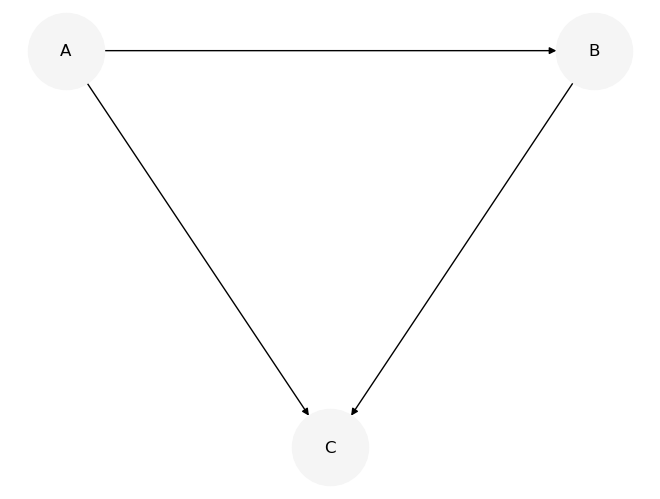

In [24]:
# create true underlying bayes net
_A_, _B_, _C_ = 0, 1, 2

A = np.array([0.1, 0.9])
B_A = np.array([[0.25, 0.8], [0.75, 0.2]])
C_AB = np.array([[[0.99, 0.5], [0.9, 0.05]], [[0.01, 0.5], [0.1, 0.95]]])

pdts = [
    (A, (_A_,)), 
    (B_A, (_B_, _A_)),
    (C_AB, (_C_, _A_, _B_)),
]

true_bn = BayesNet(*pdts)

# generate data
np.random.seed(0)
data = sample_forward(true_bn, 6000)

# unconnected bayes net to start search from
b0 = BayesNet(
    (maximum_likelihood_estimate(data, _A_), (_A_,)), 
    (maximum_likelihood_estimate(data, _B_), (_B_,)),
    (maximum_likelihood_estimate(data, _C_), (_C_,)),
)
    
best_bn = greedy_local_search(data, b0, score_fun=bic_score, successor_fun=successor_impl)

assert isinstance(best_bn, BayesNet), "'greedy_local_search' must return an instance of a Bayesian Network."

draw_graph(
    best_bn, 
    node_names=['A', 'B', 'C'], 
    pos={'A': [0., 1.], 'B': [1., 1.], 'C': [.5, .5]}
)


## Back to Strokes

---


The medicine freshman of Problem Set 3 is still trying to master her probabilistic medical world, comprising the following random variables:

 - A ... Alcoholism
 - H ... High Blood Pressure
 - S ... Stroke
 - C ... Confusion
 - V ... Vertigo
 
After trying several structures for her Bayesian Network, she is still not satisfied and sighs: "If only I had more domain knowledge, I could find the correct dependencies." At this moment, her roommate, a talented young data scientist, enters the room and asks her: "Why bother with domain knowledge? Let the data help you find the correct structure!" Taken aback, she asks him for more details, and he introduces Complete Search in Restricted Space to her.

Let's assume that we magically know the true underlying Bayes model (structure and parameters), and we can generate the data for her:

All variables in this example are boolean (false=0 or true=1).  

<img  style='width:100%;  max-width:400px;' src="img/bn_mod2.svg">

The conditional probability tables are given as follows:

<table style="float: left;margin:5px;"><tr><th>P(A)</th><th>$a_0$<br></th><th>$a_1$</th></tr><tr><td>-</td><td>0.01</td><td>0.99</td></tr></table>

<table style="float: left;margin:5px;"><tr><th>P(H | A)</th><th>$a_0$<br></th><th>$a_1$</th></tr><tr><td>$h_0$</td><td>0.9</td><td>0.8</td></tr><tr><td>$h_1$</td><td>0.1</td><td>0.2</td></tr></table>

<table style="float: left;margin:5px;"><tr><th>P(S | H)</th><th>$h_0$<br></th><th>$h_1$</th></tr><tr><td>$s_0$</td><td>0.9</td><td>0.85</td></tr><tr><td>$s_1$</td><td>0.1</td><td>0.15</td></tr></table>


<table style="float: left;margin:5px;"><tr><th rowspan="2">P(C | A, S)</th><th colspan="2">$a_0$<br></th><th colspan="2">$a_1$</th></tr><tr><td>$s_0$</td><td>$s_1$</td><td>$s_0$</td><td>$s_1$</td></tr><tr><td>$c_0$<br></td><td>0.8</td><td>0.7</td><td>0.85</td><td>0.45</td></tr><tr><td>$c_1$</td><td>0.2</td><td>0.3</td><td>0.15</td><td>0.55</td></tr></table>

<table style="float: left;margin:5px;"><tr><th>P(V | S)</th><th>$s_0$</th><th>$s_1$</th></tr><tr><td>$v_0$</td><td>0.1</td><td>0.2</td></tr><tr><td>$v_1$</td><td>0.9</td><td>0.8</td></tr></table>  

Luckily, we have three different training sets  of varying sizes (1,000, 10,000 and 20,000 data points) and a test set (10,000 data points) left that we can give to her.

In [25]:
_A_, _H_, _S_, _C_, _V_ = 0, 1, 2, 3, 4

train_small = np.loadtxt('data/train_small.txt', dtype=np.int64)
train_medium = np.loadtxt('data/train_medium.txt', dtype=np.int64)
train_big = np.loadtxt('data/train_big.txt', dtype=np.int64)
test = np.loadtxt('data/test.txt', dtype=np.int64)

Although our medicine freshman can't determine the dependencies among the random variables directly, she has some idea which of the variables might be dependent on each other and, therefore, decides to use **Complete Search in Restricted Space** to find the best model. She *defines a variable order* to restrict the search space strongly. She considers the following configurations:
<table style="border-collapse:collapse;border-spacing:0;border-color:#ccc"><tr><th style="font-family:Arial, sans-serif;font-size:14px;font-weight:bold;padding:10px 5px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#f0f0f0">Variable Order</th><th style="font-family:Arial, sans-serif;font-size:14px;font-weight:bold;padding:10px 5px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#f0f0f0">Score Function</th></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff">A, H, S, C, V</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff">Bayesian Information Criterion</td></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff">V, C, S, H, A</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff">Bayesian Information Criterion</td></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">C, A, H, V, S<br></td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">Bayesian Information Criterion</td></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">A, H, S, C, V</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">Log-Likelihood</td></tr></table>

<div class="alert alert-warning">
    
Use the `complete_search` function to learn a graph structure and the parameters for the different configurations and for all data sets (`train_small`, `train_medium`, and `train_big`). Store the bayes_net objects into the provided result variable `cs_models` and visualize the learned graph structures with `draw_graph(bayes_net)`. Use this section to analyze the results more deeply! (2 points)
</div>

*Hints:*
- You can use `log_likelihood` as a scoring function by overwriting the default choice for the named parameter `score_fun` of `complete_search`, e.g.,
```python
complete_search(data, order, score_fun=log_likelihood)
```

In [26]:
help(draw_graph)
help(evaluate_bayes_net)

Help on function draw_graph in module utils:

draw_graph(bayes_net: bayesian_network.BayesNet, node_names: list = None, pos: dict = None) -> None
    Draws the Bayesian net.
    :param bayes_net: a BayesNet object representing the graph structure to draw.
    :param node_names: Display Name of the variables. 
                       Defaults to values for the stroke-example.
    :param pos: position of the variables (dict: key=variable_name, value: list: x, y). 
                Defaults to values for the stroke-example.

Help on function evaluate_bayes_net in module utils:

evaluate_bayes_net(bayes_net: bayesian_network.BayesNet, train_set: numpy.ndarray, test_set: numpy.ndarray) -> tuple
    Computes the mean likelihood of the Bayesian network under the training and test data
    :param bayes_net: a BayesNet object, representing the model.
    :param train_set: the training set, a NumPy array of shape (num_samples, len(bayes_net)).
    :param test_set: the test set, a Numpy array (num_

In [27]:
### this is part of a hidden test; don't remove...

Current dataset size:  small | Current ordering type:  ordered
evaluation score log-likelihood for train and test set:  (-2.2656179231177354, -2.2860122349916487)


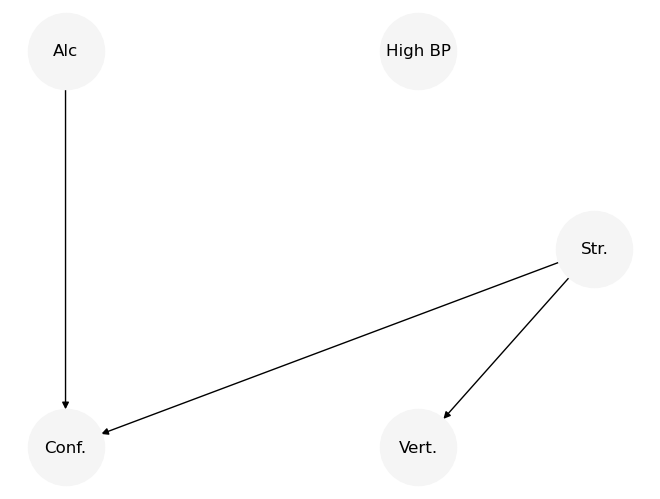

Current dataset size:  small | Current ordering type:  reverse
evaluation score log-likelihood for train and test set:  (-2.267043562082772, -2.288878094072046)


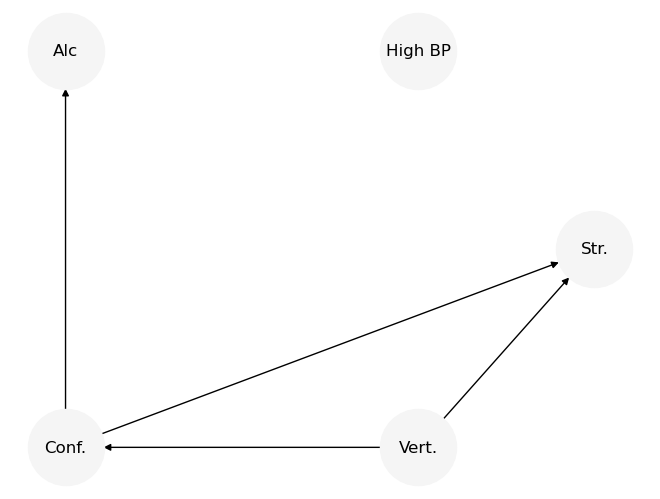

Current dataset size:  small | Current ordering type:  random
evaluation score log-likelihood for train and test set:  (-2.2670376079509005, -2.289015300268186)


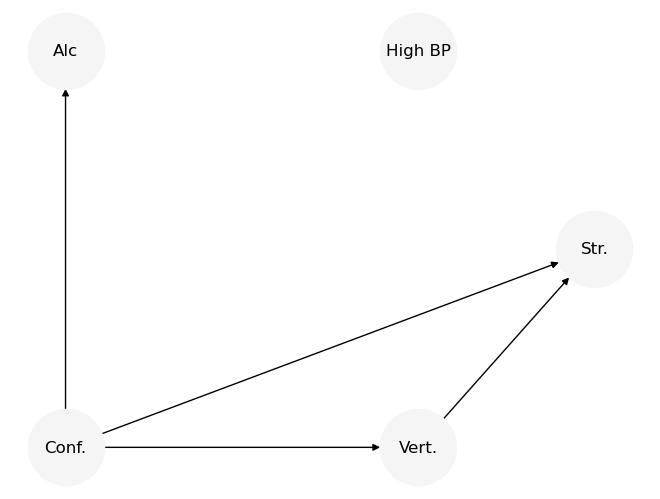

Current dataset size:  small | Current ordering type:  log-likelihood
evaluation score log-likelihood for train and test set:  (-2.248921260376673, -2.2925404144132795)


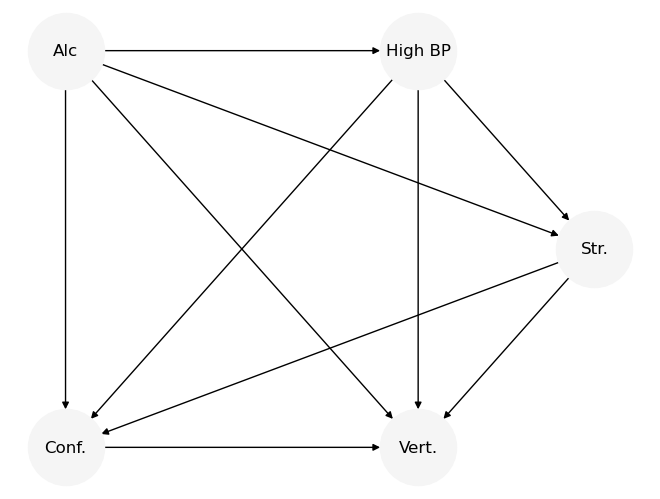

Current dataset size:  medium | Current ordering type:  ordered
evaluation score log-likelihood for train and test set:  (-2.2488427836002454, -2.2737989830944856)


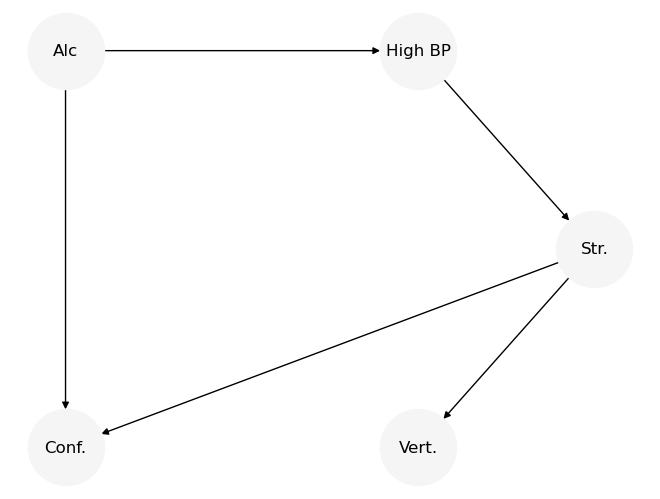

Current dataset size:  medium | Current ordering type:  reverse
evaluation score log-likelihood for train and test set:  (-2.2489564154579504, -2.2742566044980563)


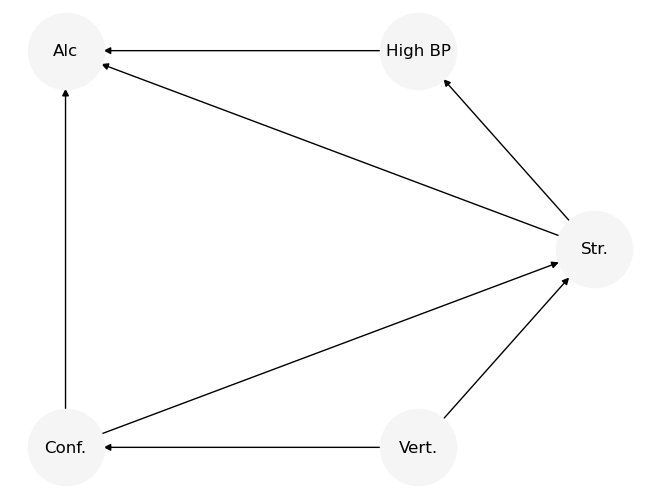

Current dataset size:  medium | Current ordering type:  random
evaluation score log-likelihood for train and test set:  (-2.2503538510354133, -2.275167130925458)


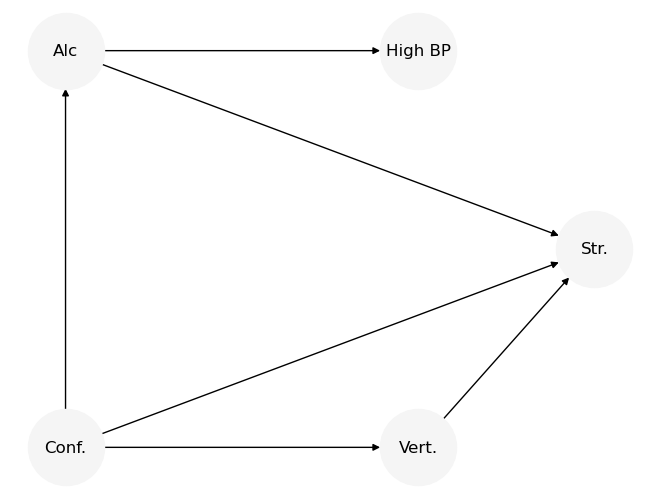

Current dataset size:  medium | Current ordering type:  log-likelihood
evaluation score log-likelihood for train and test set:  (-2.248332369063138, -2.27440768857188)


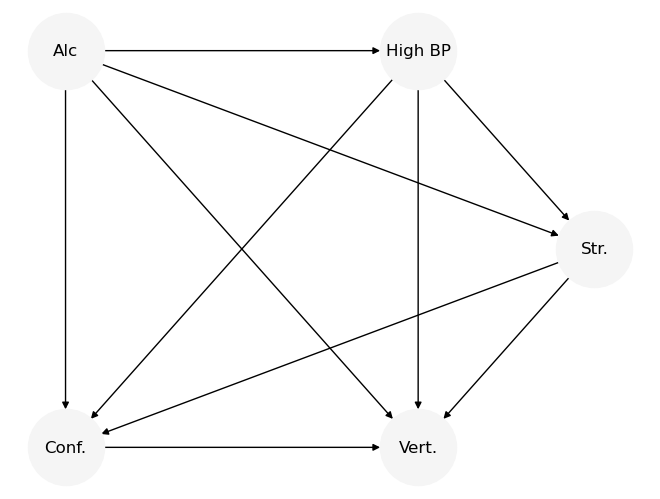

Current dataset size:  big | Current ordering type:  ordered
evaluation score log-likelihood for train and test set:  (-2.2821695234295554, -2.273298826096675)


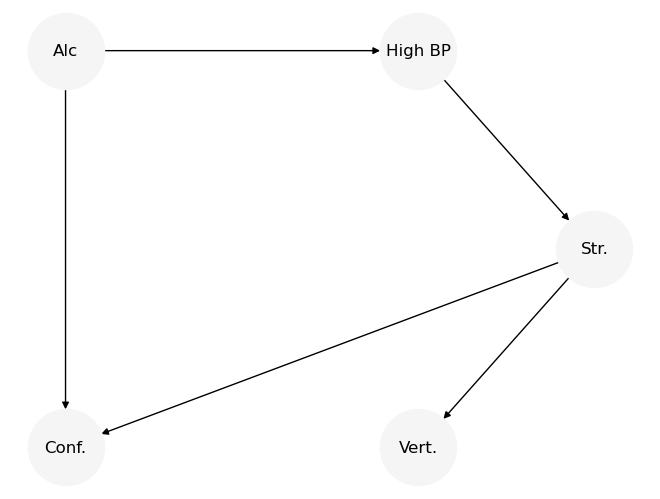

Current dataset size:  big | Current ordering type:  reverse
evaluation score log-likelihood for train and test set:  (-2.2824182993835245, -2.2734982104055574)


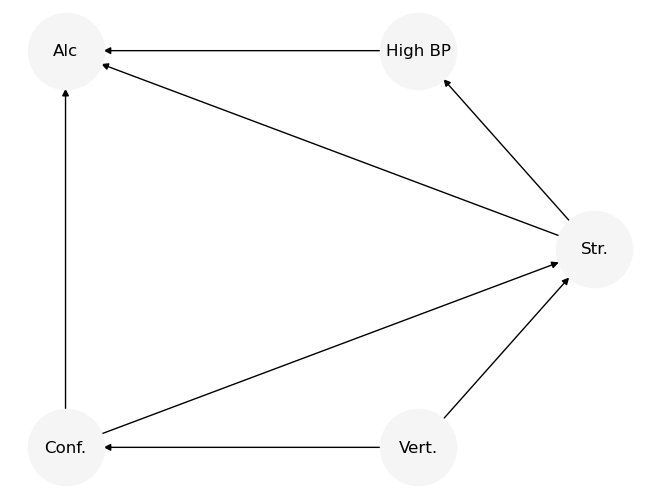

Current dataset size:  big | Current ordering type:  random
evaluation score log-likelihood for train and test set:  (-2.2834927501447155, -2.2744997123513135)


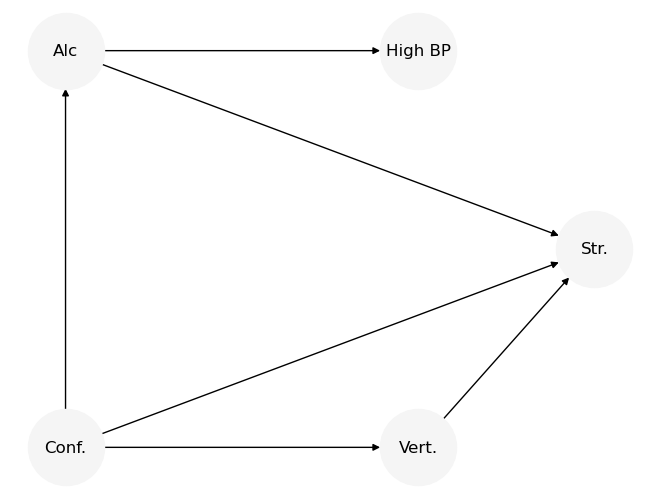

Current dataset size:  big | Current ordering type:  log-likelihood
evaluation score log-likelihood for train and test set:  (-2.2817161515785354, -2.273798673301265)


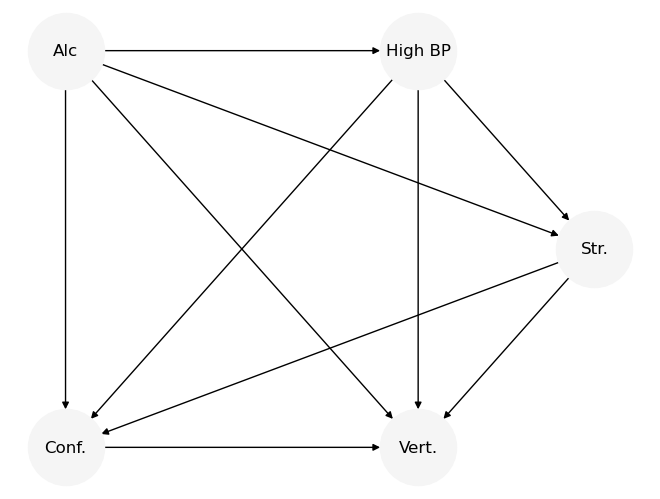

In [28]:
cs_models = {}
for data_set_size in ['small', 'medium', 'big']:
    cs_models[data_set_size] = {
            'ordered': None, # _A_, _H_, _S_, _C_, _V_; bic_score
            'reverse': None, # _V_, _C_, _S_, _H_, _A_; bic_score
            'random': None, # _C_, _A_, _H_, _V_, _S_; bic_score
            'log-likelihood': None, # _A_, _H_, _S_, _C_, _V_; log_likelihood
        }
    
    if data_set_size == 'small':
        cur_data = train_small  
    
    elif data_set_size == 'medium':
        cur_data = train_medium
        
    else:
        cur_data = train_big
    
    
    for variable_order_type in cs_models[data_set_size].keys():
        
        if variable_order_type=='ordered':
            variable_order_in = [_A_, _H_, _S_, _C_, _V_] # the given topological order
            score_fun_in = bic_score
        
        elif variable_order_type=='reverse':
            variable_order_in = [_V_, _C_, _S_, _H_, _A_]
            score_fun_in = bic_score
            
        elif variable_order_type=='random':
            variable_order_in = [_C_, _A_, _H_, _V_, _S_]
            score_fun_in = bic_score
            
        else:
            variable_order_in = [_A_, _H_, _S_, _C_, _V_]
            score_fun_in = log_likelihood

        found_bn = complete_search(data=cur_data, variable_order=variable_order_in, score_fun=score_fun_in)
        cs_models[data_set_size][variable_order_type] = found_bn

        score = evaluate_bayes_net(found_bn, cur_data, test) # you mentioned this function above. I am not
        # 100 % sure if your intent is it to use it.

        print('Current dataset size: ' ,data_set_size , '| Current ordering type: ', variable_order_type)
        print('evaluation score log-likelihood for train and test set: ', score)
        draw_graph(found_bn) 

In [29]:
for data_set_id in ['small', 'medium', 'big']:
    for combination_id in ['ordered', 'reverse', 'random', 'log-likelihood']:
        assert type(cs_models[data_set_id][combination_id]) is BayesNet
        

Our medicine freshman is still trying to figure out the resulting Bayesian Network structures. She questions her understanding of medicine and asks herself if the variable orderings she specified were correct. She turns to her roommate and asks him what to do if she is unsure about the correct variable ordering. He suggests a heuristic search in the full space to her.

Our medicine freshman turns to **Heuristic Search in Full Space**. She considers the following configurations:

<table style="border-collapse:collapse;border-spacing:0;border-color:#ccc"><tr><th style="font-family:Arial, sans-serif;font-size:14px;font-weight:bold;padding:10px 5px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#f0f0f0">Starting Structure</th><th style="font-family:Arial, sans-serif;font-size:14px;font-weight:bold;padding:10px 5px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#f0f0f0">Score Function</th></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff">Unconnected</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff">Bayesian Information Criterion</td></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff">Result Complete Search: log-likelihood</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff">Bayesian Information Criterion</td></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">Result Complete Search: ordered<br></td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">Bayesian Information Criterion</td></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">Unconnected</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;vertical-align:top">Log-Likelihood</td></tr></table>

*Starting Structure* determines the structure of `bayes_net` that we pass to `greedy_local_search`. The two settings *Result Complete Search: log-likelihood* and *Result Complete Search: ordered* refer to the structures we obtained as the result of *Complete Search in Restricted Space* with the variable ordering *A, H, S, C, V* using the bic score and the log-likelihood as score function, respectively. 

<div class="alert alert-warning">
    
Use the `greedy_local_search` function to learn a graph structure and the parameters for the different configurations and for all data sets (`train_small`, `train_medium`, and `train_big`). Store the bayes_net objects into the provided result variable `hs_models` and visualize the learned graph structures with `draw_graph(bayes_net)`. Use this section to analyze the results more deeply! (2 points)
</div>

**Important**: For the starting structures obtained by *Complete Search in Restricted Space*, the dataset sizes must match. For instance, if you run the configuration with starting structure *Result Complete Search: ordered* on `train_medium`, you will use `cs_models['medium']['ordered']` as the starting structure passed to `greedy_local_search` (and likewise `cs_models['small']['ordered']` for `train_small` and `cs_models['large']['ordered']` for `train_large`).

*Hints:*
- You can use `log_likelihood` as a scoring function by overwriting the default choice for the named parameter `score_fun` of `greedy_local_search`, e.g.,
```python
greedy_local_search(data, order, score_fun=log_likelihood)
```

In [30]:
### this is part of a hidden test; don't remove...

Current dataset size:  small | Current ordering type:  log-likelihood
evaluation score log-likelihood for train and test set:  (-2.267798048221481, -2.2883786942899276)


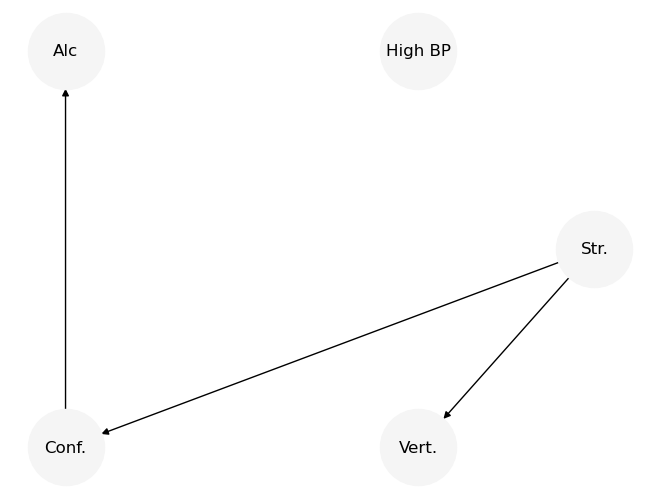

Current dataset size:  small | Current ordering type:  log-likelihood
evaluation score log-likelihood for train and test set:  (-2.250821920387027, -2.2737561017717876)


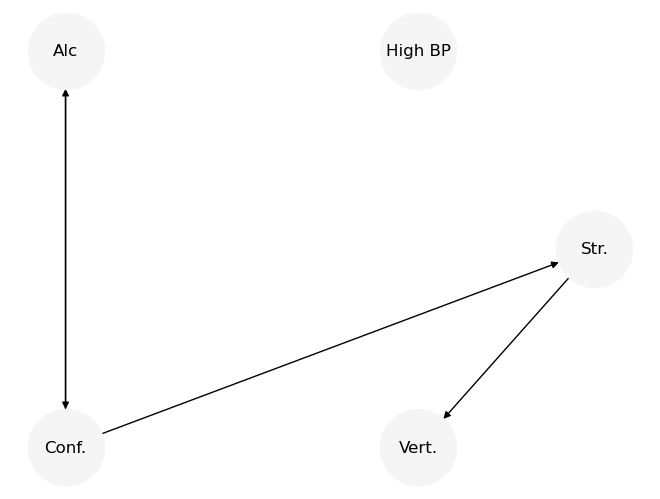

Current dataset size:  small | Current ordering type:  log-likelihood
evaluation score log-likelihood for train and test set:  (-2.250821920387027, -2.2737561017717876)


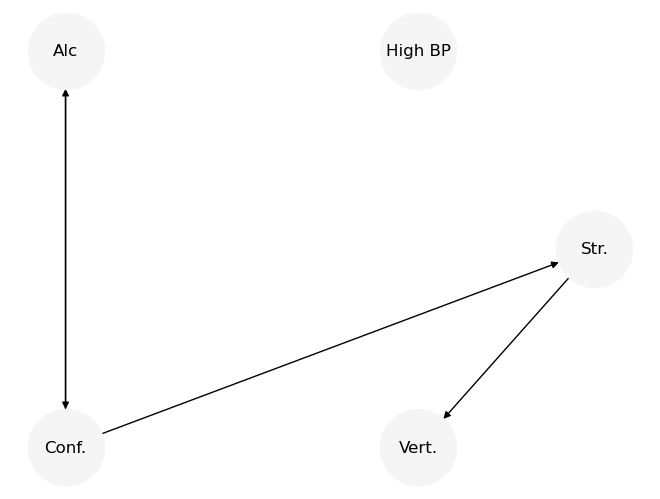

Current dataset size:  small | Current ordering type:  log-likelihood
evaluation score log-likelihood for train and test set:  (-2.250821920387027, -2.2737561017717876)


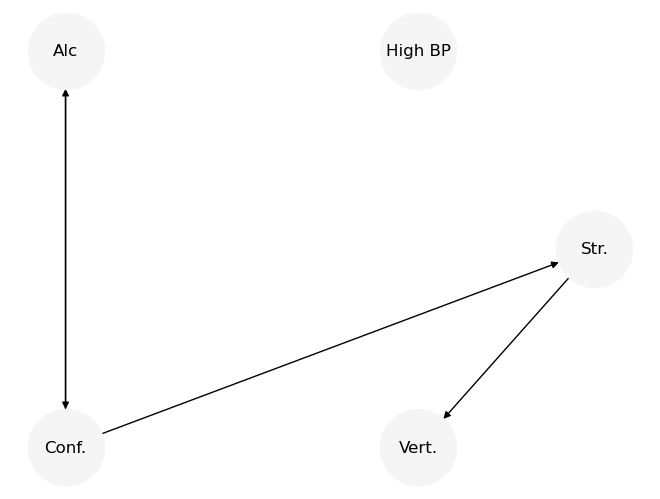

Current dataset size:  medium | Current ordering type:  log-likelihood
evaluation score log-likelihood for train and test set:  (-2.242782782548949, -2.267341271440207)


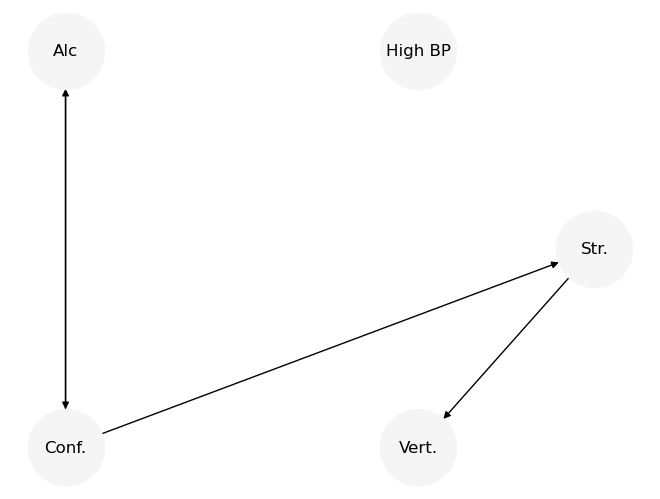

Current dataset size:  medium | Current ordering type:  log-likelihood
evaluation score log-likelihood for train and test set:  (-2.2357021178455745, -2.2618254643356885)


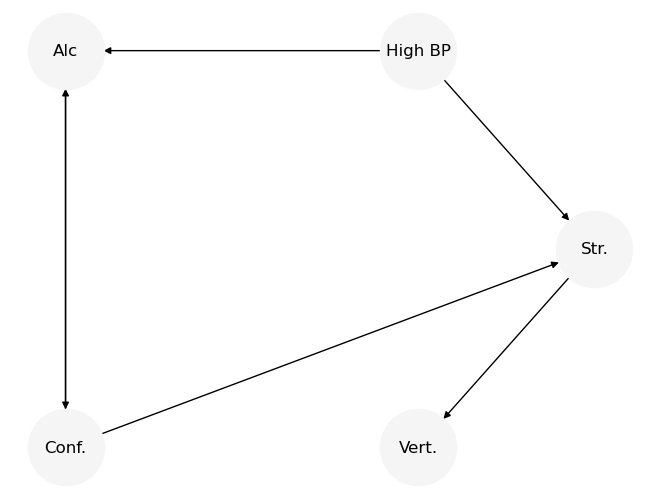

Current dataset size:  medium | Current ordering type:  log-likelihood
evaluation score log-likelihood for train and test set:  (-2.2357021178455745, -2.2618254643356885)


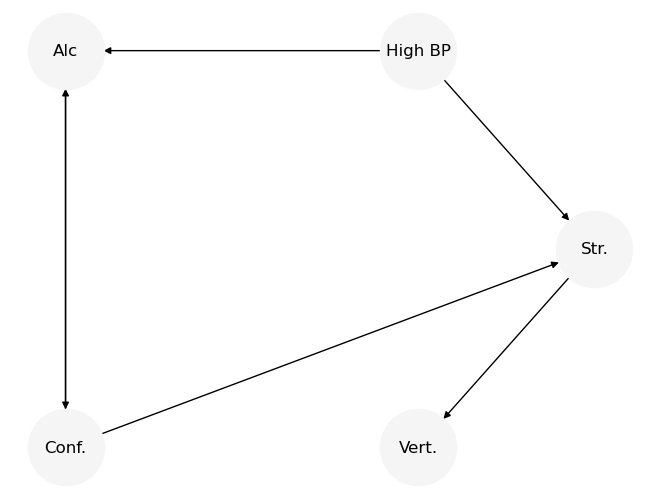

Current dataset size:  medium | Current ordering type:  log-likelihood
evaluation score log-likelihood for train and test set:  (-2.242782782548949, -2.267341271440207)


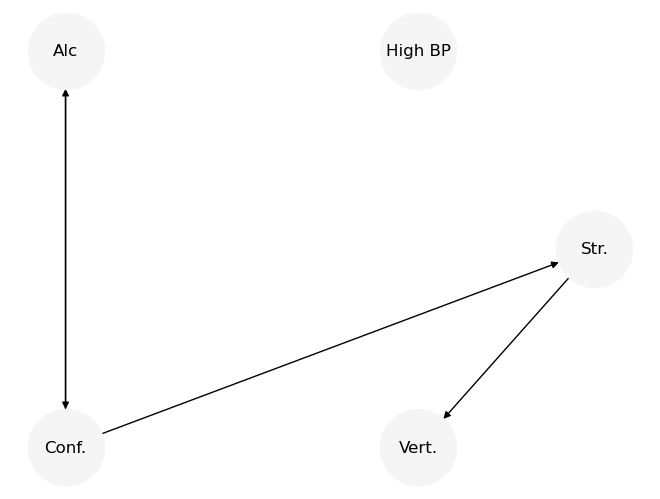

Current dataset size:  big | Current ordering type:  log-likelihood
evaluation score log-likelihood for train and test set:  (-2.2755510455486148, -2.2670172327876266)


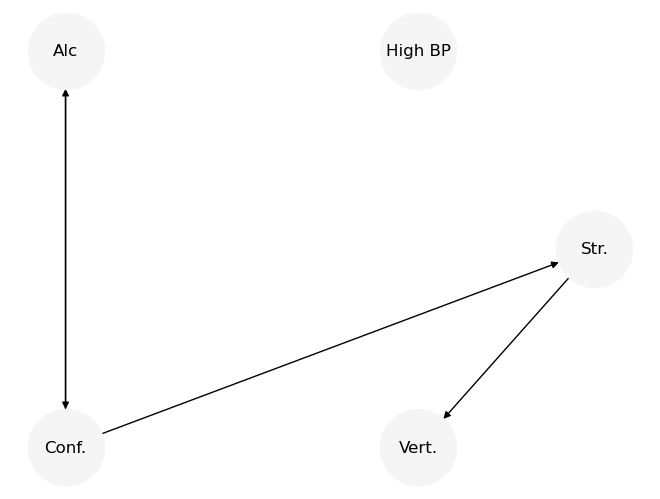

Current dataset size:  big | Current ordering type:  log-likelihood
evaluation score log-likelihood for train and test set:  (-2.2684702894190454, -2.26145467216301)


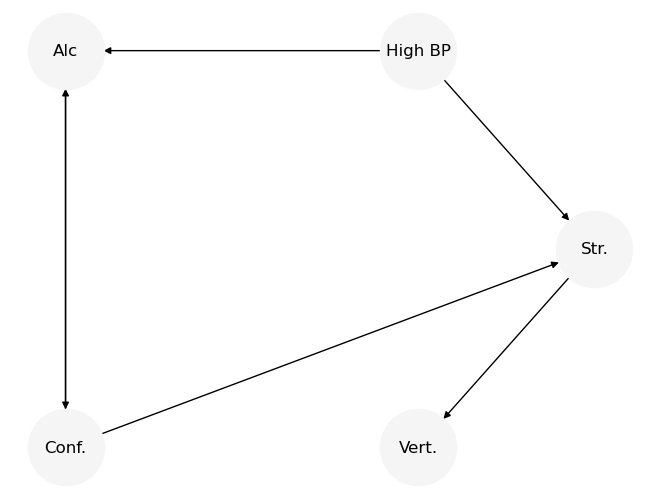

Current dataset size:  big | Current ordering type:  log-likelihood
evaluation score log-likelihood for train and test set:  (-2.2684702894190454, -2.26145467216301)


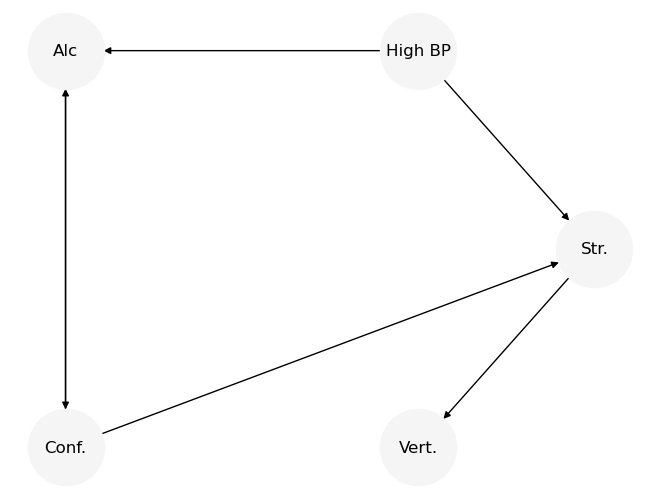

Current dataset size:  big | Current ordering type:  log-likelihood
evaluation score log-likelihood for train and test set:  (-2.2755510455486148, -2.2670172327876266)


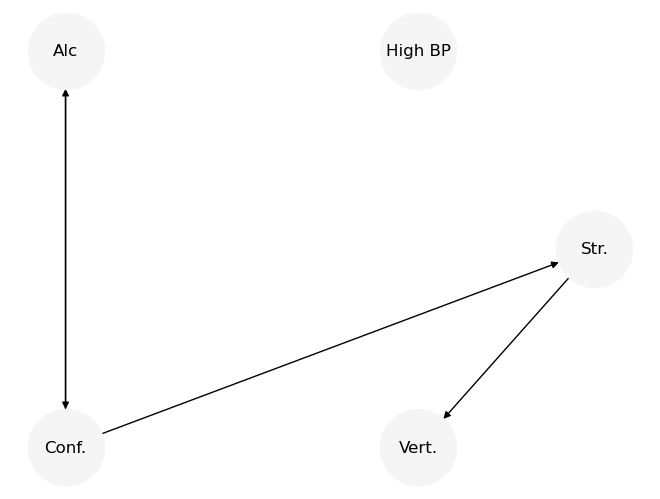

In [31]:
hs_models = {} 
for data_set_size in ['small', 'medium', 'big']:
    hs_models[data_set_size] = {
                    'unconnected': None,  # unconnected network; bic score
                    'cs_log-likelihood': None,  # network resulting from complete search ('log-likelihood'); bic score
                    'cs_ordered': None,  # network resulting from complete search ('ordered'); bic score
                    'log-likelihood': None  # unconnected; log-likelihood
            } 
    if data_set_size == 'small':
        cur_data = train_small  
    
    elif data_set_size == 'medium':
        cur_data = train_medium
        
    else:
        cur_data = train_big
        
    for type_ in hs_models[data_set_size].keys():
        
        if type_ == 'unconnected' or type_=='log-likelihood':
            
            # unconnected bayes net to start search from
            start_bn = BayesNet(
                (maximum_likelihood_estimate(cur_data, _A_), (_A_,)), 
                (maximum_likelihood_estimate(cur_data, _H_), (_H_,)),
                (maximum_likelihood_estimate(cur_data, _S_), (_S_,)),
                (maximum_likelihood_estimate(cur_data, _C_), (_C_,)),
                (maximum_likelihood_estimate(cur_data, _V_), (_V_,)),
            )
            
            if type_ == 'unconnected':
                cur_score_fun = bic_score
            else:
                cur_score_fun = log_likelihood
            
            
        elif type_ == 'cs_log-likelihood':
            start_bn = cs_models[data_set_size]['log-likelihood']
            cur_score_fun = bic_score
            
        else:
            start_bn = cs_models[data_set_size]['ordered']
            cur_score_fun = bic_score
                        
        found_bn = greedy_local_search(data=cur_data, bayes_net=start_bn, score_fun=cur_score_fun)
        hs_models[data_set_size][type_] = found_bn

        score = evaluate_bayes_net(found_bn, cur_data, test) # you mentioned this function above. I am not
        # 100 % sure if your intent is it to use it.


        print('Current dataset size: ' ,data_set_size , '| Current ordering type: ', variable_order_type)
        print('evaluation score log-likelihood for train and test set: ', score)
        draw_graph(found_bn) 

In [32]:
for data_set_id in ['small', 'medium', 'big']:
    for combination_id in ['unconnected', 'cs_log-likelihood', 'cs_ordered', 'log-likelihood']:
        assert type(hs_models[data_set_id][combination_id]) is BayesNet
        

### Interpret the Results in Detail

In the following, we will compare all learned Bayesian Network structures (stored in variables `cs_models` and `hs_models`) w.r.t. their log-likelihoods on train and test datasets.

The first plots visualizes the training set size's influence on the log-likelihood relative to the test data.

**Complete Search in Restricted Space:**

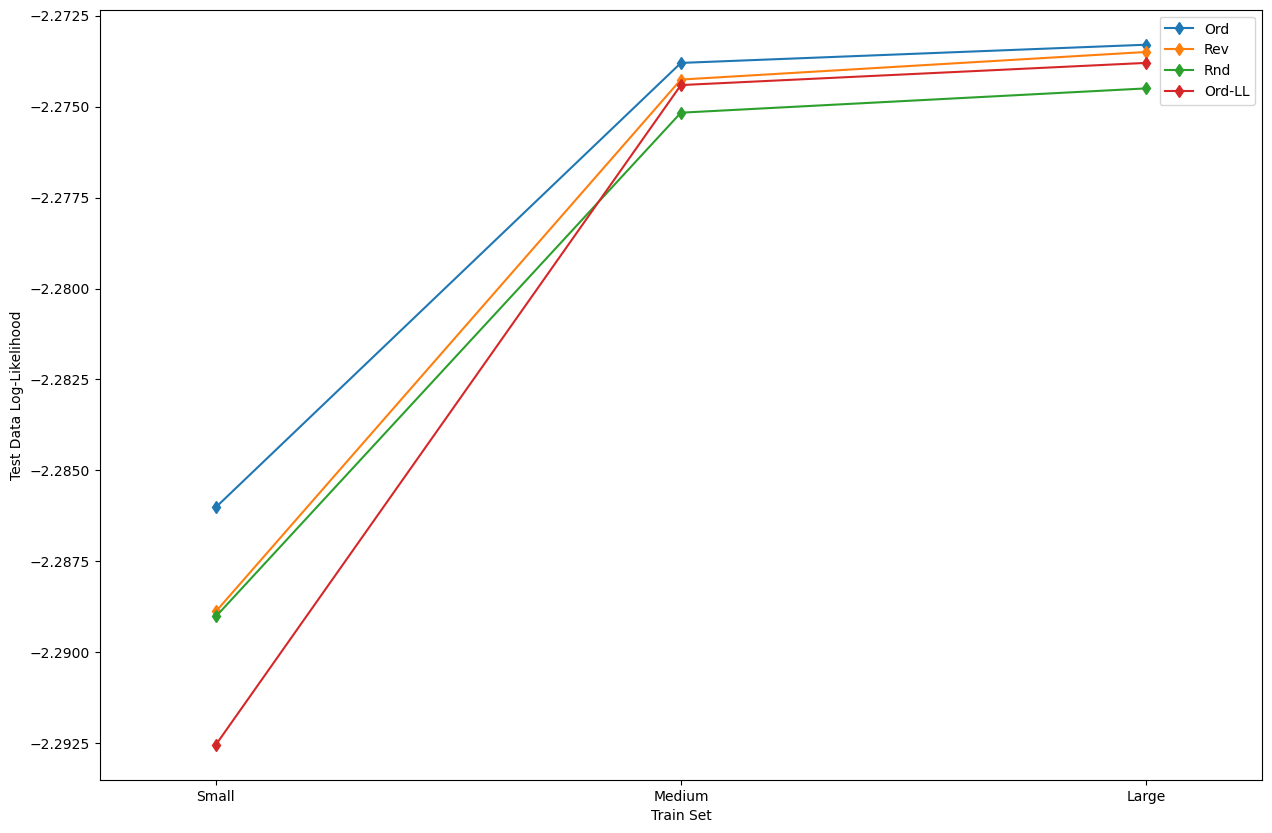

In [33]:
from utils import plot_compare_orders, compare_train_size

compare_train_size(cs_models, [train_small, train_medium, train_big], test)

**Heuristic Search in Full Space**:

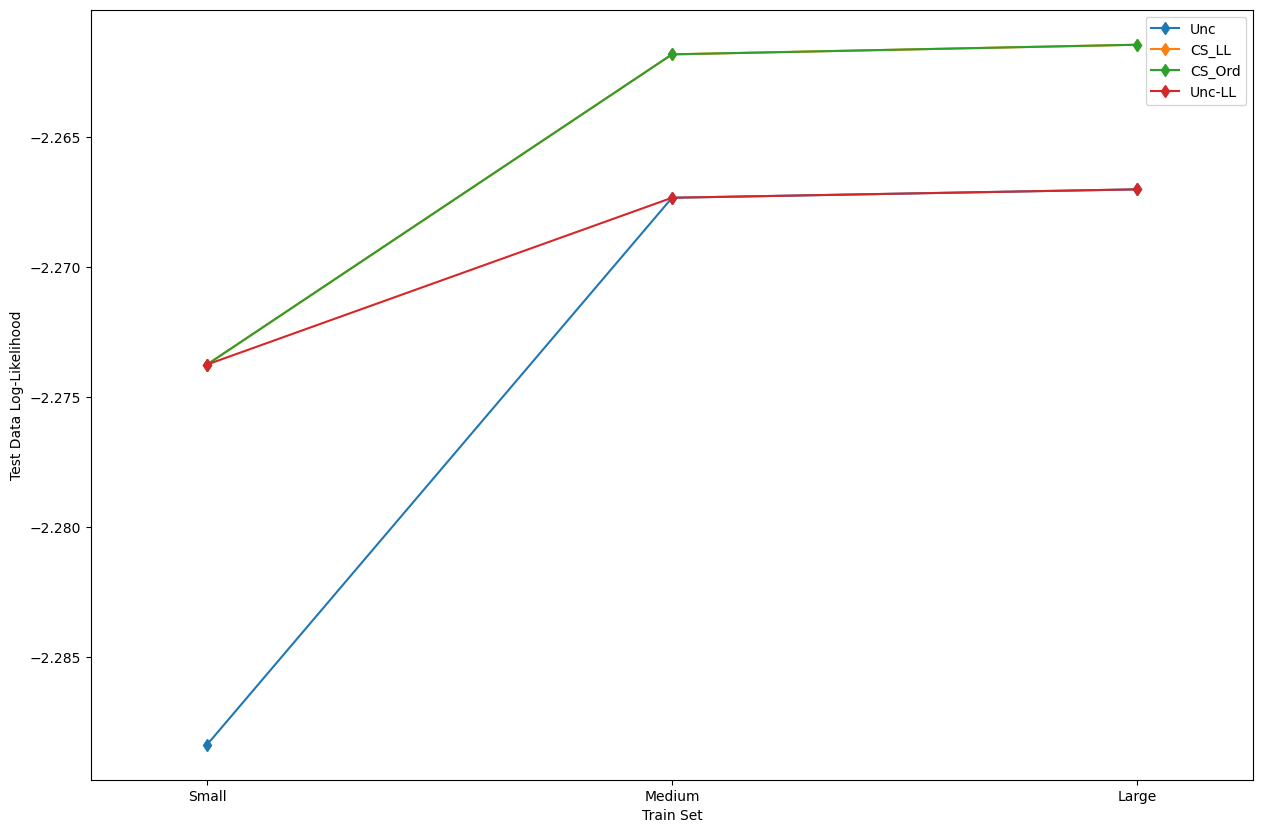

In [34]:
compare_train_size(hs_models, [train_small, train_medium, train_big], test, cs=False)

The plot compares all configurations' log-likelihood relative to the training and test data for each dataset size.

**Complete Search in Restricted Space:**

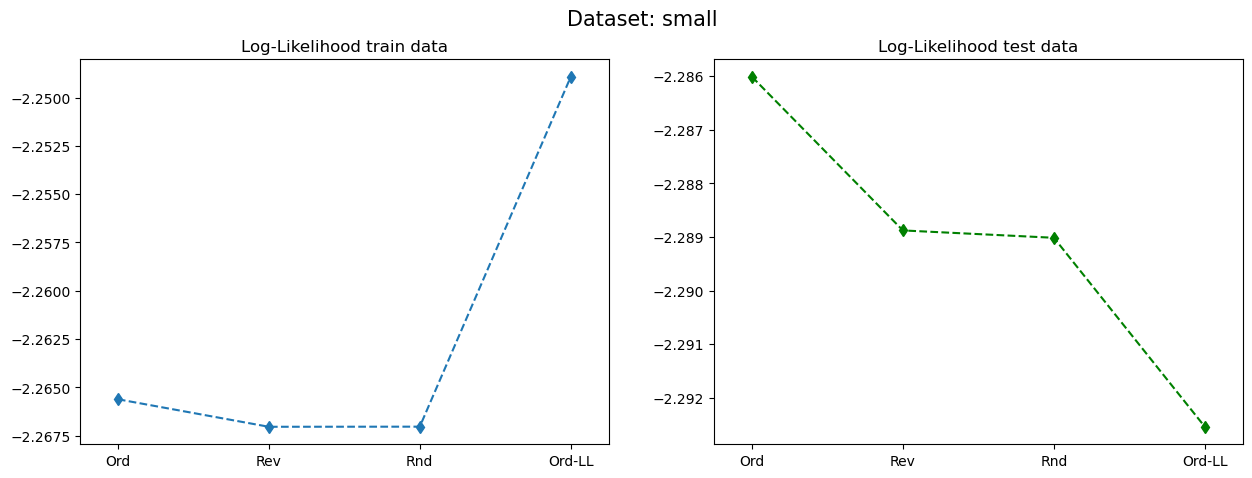

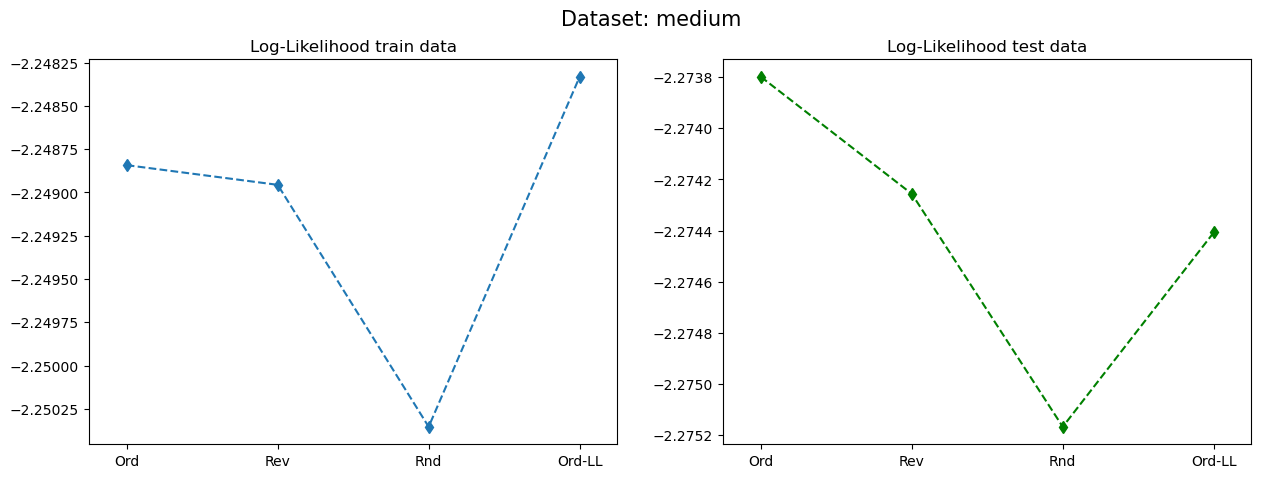

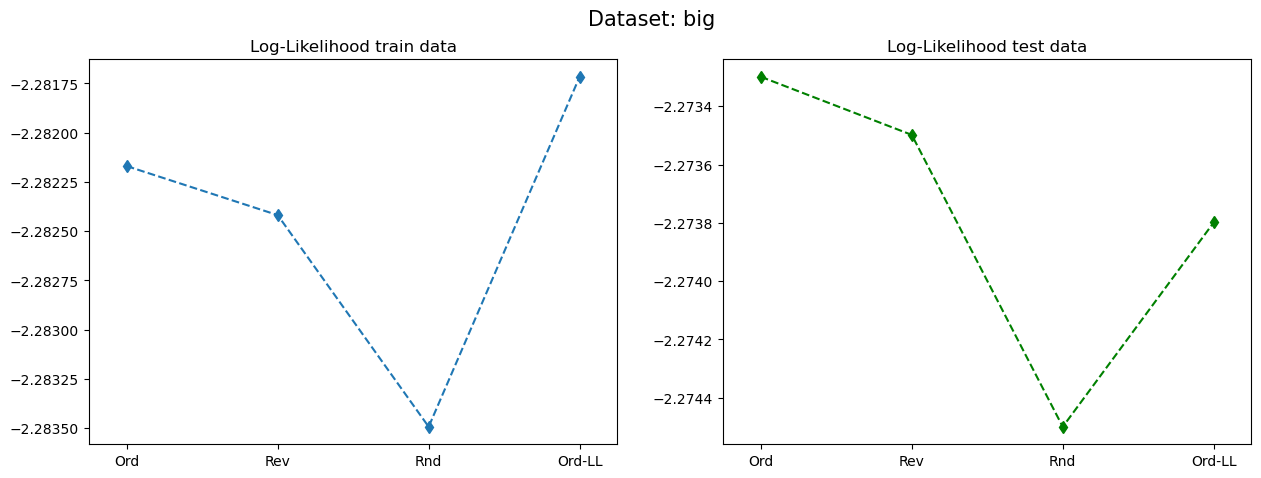

In [35]:
plot_compare_orders(cs_models, [train_small, train_medium, train_big], test)

**Heuristic Search in Full Space**:

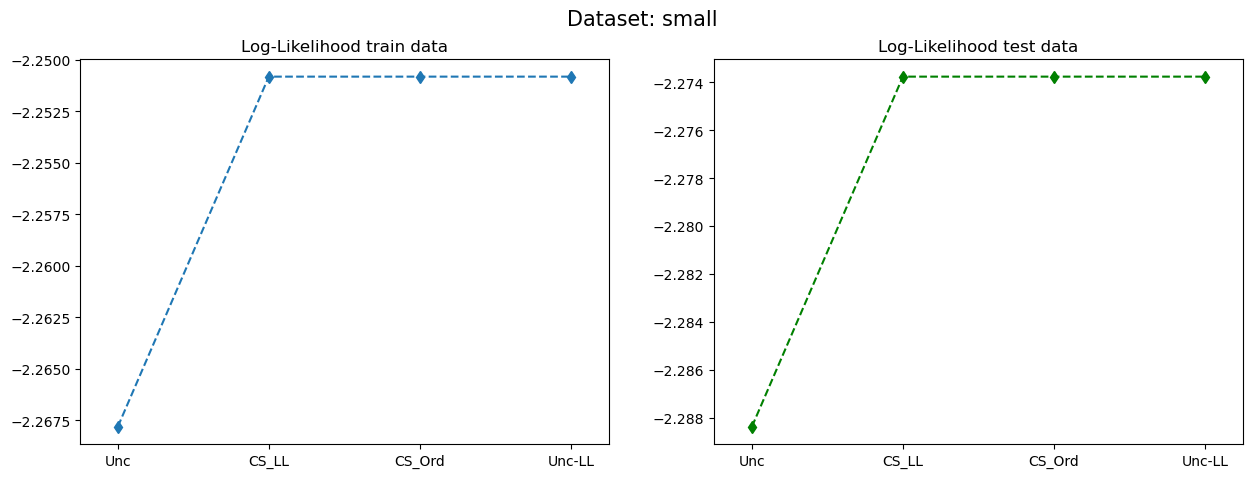

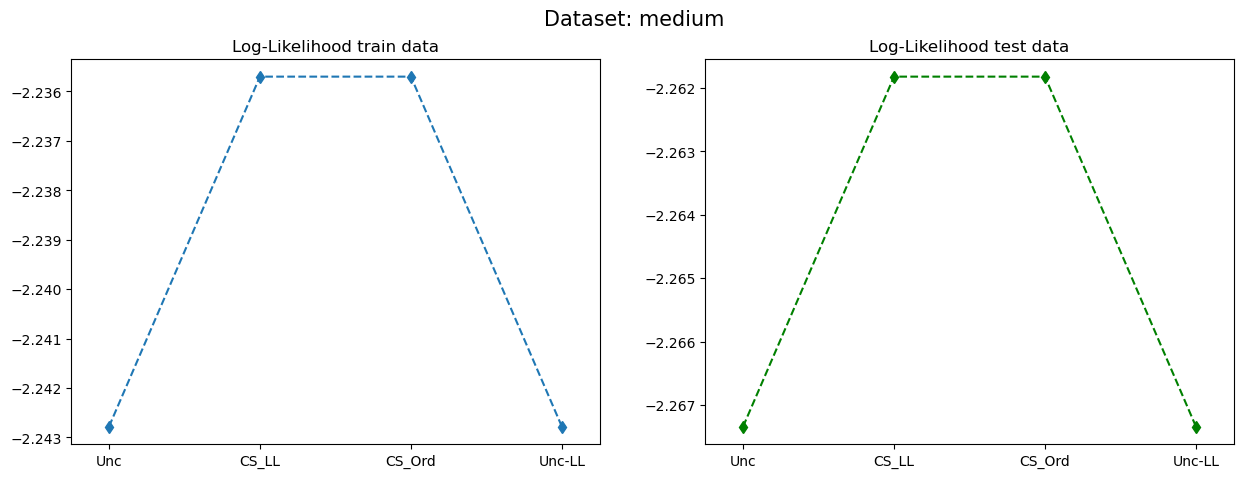

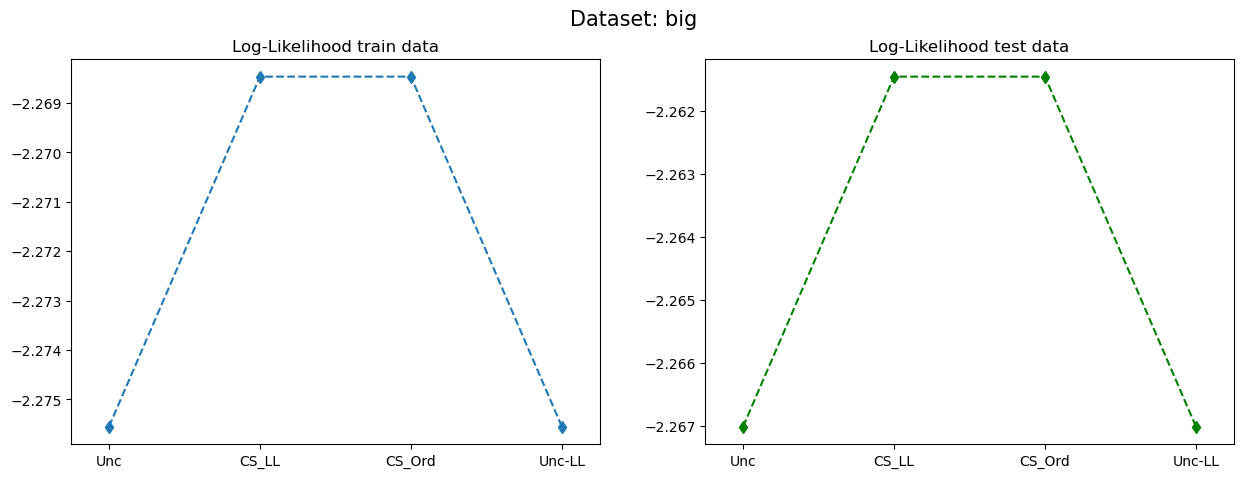

In [36]:
plot_compare_orders(hs_models, [train_small, train_medium, train_big], test, cs=False)

<div class="alert alert-warning">
Consider the implemented functions and the resulting plots in more detail and answer the following four questions *briefly*. (1 point each)
</div>

Looking at the plots and the test likelihood scores: (1) In this specific situation, which advice would you give to our medicine freshman, should she use **Complete Search in Restricted Space** or **Heuristic Search in Full Space**? (2) In general, in which situations would you recommend to use **Complete Search in Restricted Space** with a predefined variable order and in which **Heuristic Search in Full Space**?

(1) Heuristic Search in Full Space as in the test data log-likelihood only one value is smaller than -2.275, in comparison to that Complete Search in Restricted Space has five values below. 
<br>
(2) Search in Restricted Space seems to be preferable when the topological order is known and only few nodes exist. Heuristic Search in Full Space seems to be superior when no knowledge about the edges/graph structure is given. 

Given a specific train dataset and the BIC score as the scoring function. Let's assume that we apply **Complete Search in Restricted Space** with the correct ordering of variables (i.e., one that corresponds to a topological ordering of the variables in the Bayesian Network representing the true underlying full joint distribution). Let's further assume that **Complete Search in Restricted Space** returns a good but suboptimal structure. Can we discover the true underlying structure by passing the suboptimal structure as the starting structure to our **Heuristic Search in Full Space** algorithm?

Yes, when the Heuristic Search in Full Space algorithm uses BIC as scoring function because BIC uses the log-liklihood, which never decreases through added edges, but there is a penalty for adding unneeded edges through Dim[G] (formula lecture 5b, page 49).<br>
(Not really, when it uses the log-likelihood scoring function as the likelihood never decreases when a new edge is added, so we would probably end up with more edges then the ground truth has.)

Given specific train and test datasets and the BIC score as the scoring function. Let's assume that we apply **Complete Search in Restricted Space** with the correct ordering of variables. Can **Heuristic Search in Full Space** find a Bayesian Network that scores higher with regard to the train and test sets than the solution found by **Complete Search in Restricted Space**?

Search in Restricted Space algorithm has a look at every possible parent candidate and combination, given that no unneeded penalty through Dim[G] in BIC takes place. This is optimial, therefore the answer is NO.

Let $N \gt 3$ denote the number of random variables in a specific probabilistic model. Given two arbitrary Bayesian Networks $G_1$ and $G_2$ and the search operators we implemented in this problem set. Select the smallest number of search steps (one step = modifying one edge with one of our three implemented search operators) from the possible answers below that guarantees us to be able to traverse the search space from $G_1$ to $G_2$.

(1) $N$

(2) $N^2$

(3) $2^N$

(4) $N!$

(5) $N^N$

Store the correct answer 1-5 in the provided variable `results`.

In [37]:
result = 5 # 4 to find an edge, 5 to find an edge (put in) and also consider its direction

In [38]:
assert result is not None
assert result in [1,2,3,4,5]